<a href="https://colab.research.google.com/github/glpappa/ML4Health/blob/main/EP2_reg_linear.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exercício Prático 2

### Regressão linear múltipla

* Objetivo: Prever a quantidade de dias de internação (length of stay - LoS) de um paciente no CTI utilizando atributos demográficos e sinais vitais do primeiro dia de hospitalização. 
* O notebook foi baseado no trabalho de [Alghatani et. al (2021)](https://doi.org/10.2196/21347) e alguns trechos do artigo foram transcritos.
* Para o pessoal da pós-graduação, tente adicionar outros atributos a análise após obter os primeiros resultados.

In [ ]:
from google.cloud import bigquery
from collections import OrderedDict
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import Normalizer

from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectPercentile
from sklearn.feature_selection import chi2
from sklearn.compose import make_column_selector as selector
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.compose import make_column_transformer

In [ ]:
from google.colab import auth
auth.authenticate_user()

In [ ]:
projeto = 'mimic-ml-01' # Project ID inserted based on the query results selected to explore
location = 'US' # Location inserted based on the query results selected to explore

dataset_hosp = 'physionet-data.mimiciv_hosp'
dataset_icu = 'physionet-data.mimiciv_icu'
dataset_ed = 'physionet-data.mimiciv_ed'
dataset_note = 'physionet-data.mimiciv_note'
dataset_cxr = 'physionet-data.mimic_cxr'

## 1. Seleção da amostra

In [ ]:
sql = """
SELECT * FROM `""" + dataset_icu + """.icustays`;"""
estadias_icu = pd.read_gbq(sql, projeto) 

In [ ]:
estadias_icu.shape

(73181, 8)

> *Patients who stayed in the ICU for at least 1 day. We considered their data for only the first day.*



In [ ]:
estadias_icu = estadias_icu[estadias_icu['los'] > 1]
estadias_icu.shape

(57732, 8)

In [ ]:
estadias_icu['stay_id'].unique().size

57732

In [ ]:
estadias_icu.head()

,subject_id,hadm_id,stay_id,first_careunit,last_careunit,intime,outtime,los
0,10004113,29879900,35200789,Neuro Stepdown,Neuro Stepdown,2173-03-20 20:16:36,2173-03-21 21:43:59,1.060683
1,10018328,23786647,31269608,Neuro Stepdown,Neuro Stepdown,2154-04-24 23:03:44,2154-05-02 15:55:21,7.702512
2,10019607,24546857,34178938,Neuro Stepdown,Neuro Stepdown,2167-03-19 17:37:39,2167-03-21 13:12:28,1.815845
4,10028930,26238833,33941522,Neuro Stepdown,Neuro Stepdown,2172-08-28 13:11:37,2172-08-29 14:19:35,1.047199
5,10067921,27475639,31097260,Neuro Stepdown,Neuro Stepdown,2128-07-15 00:55:00,2128-07-16 11:41:23,1.448877


In [ ]:
estadias_icu = estadias_icu.loc[:,['subject_id','hadm_id','stay_id','los']].drop_duplicates()



> *We focused on six vital sign features (body temperature, heart rate, respiration rate, systolic blood pressure, diastolic blood pressure, and oxygen saturation [SpO2]) along with glucose level.*


* Seleção dos sinais vitais dos pacientes nas primeiras 24h.
* A consulta abaixo foi baseada em https://github.com/MIT-LCP/mimic-iv/blob/master/concepts/firstday/first_day_vitalsign.sql.

In [ ]:
sql = """
-- This query pivots vital signs and aggregates them
-- for the first 24 hours of a patient's stay.
SELECT
ie.subject_id
, ie.stay_id
, MIN(heart_rate) AS heart_rate_min
, MAX(heart_rate) AS heart_rate_max
, AVG(heart_rate) AS heart_rate_mean
, MIN(sbp) AS sbp_min
, MAX(sbp) AS sbp_max
, AVG(sbp) AS sbp_mean
, MIN(dbp) AS dbp_min
, MAX(dbp) AS dbp_max
, AVG(dbp) AS dbp_mean
, MIN(mbp) AS mbp_min
, MAX(mbp) AS mbp_max
, AVG(mbp) AS mbp_mean
, MIN(resp_rate) AS resp_rate_min
, MAX(resp_rate) AS resp_rate_max
, AVG(resp_rate) AS resp_rate_mean
, MIN(temperature) AS temperature_min
, MAX(temperature) AS temperature_max
, AVG(temperature) AS temperature_mean
, MIN(spo2) AS spo2_min
, MAX(spo2) AS spo2_max
, AVG(spo2) AS spo2_mean
, MIN(glucose) AS glucose_min
, MAX(glucose) AS glucose_max
, AVG(glucose) AS glucose_mean
FROM `physionet-data.mimiciv_icu.icustays` ie
LEFT JOIN `physionet-data.mimiciv_derived.vitalsign` ce
    ON ie.stay_id = ce.stay_id
    AND ce.charttime >= DATETIME_SUB(ie.intime, INTERVAL '6' HOUR)
    AND ce.charttime <= DATETIME_ADD(ie.intime, INTERVAL '1' DAY)
GROUP BY ie.subject_id, ie.stay_id;"""

sinais_vitais_dia1 = pd.read_gbq(sql, projeto)

In [ ]:
sinais_vitais_dia1.head()

,subject_id,stay_id,heart_rate_min,heart_rate_max,heart_rate_mean,sbp_min,sbp_max,sbp_mean,dbp_min,dbp_max,...,resp_rate_mean,temperature_min,temperature_max,temperature_mean,spo2_min,spo2_max,spo2_mean,glucose_min,glucose_max,glucose_mean
0,17375900,34942552,74.0,109.0,89.625000,140.0,207.0,179.000000,84.0,117.0,...,14.125000,36.390000000,37.560000000,36.851666667,97.0,100.0,99.083333,110.0,243.0,180.857143
1,12614621,37408921,70.0,104.0,85.333333,125.0,155.0,138.250000,72.0,119.0,...,17.466667,36.670000000,37.170000000,36.898571429,96.0,98.0,96.444444,74.0,123.0,94.200000
2,12766546,39448784,67.0,90.0,80.750000,138.0,152.0,145.000000,88.0,95.0,...,18.000000,36.890000000,36.890000000,36.890000000,98.0,99.0,98.500000,114.0,114.0,114.000000
3,15678285,33352302,60.0,63.0,60.166667,104.0,161.0,144.473684,71.0,111.0,...,20.958333,36.670000000,37.110000000,36.856000000,91.0,100.0,96.166667,96.0,96.0,96.000000
4,17853367,38547150,84.0,135.0,111.000000,120.0,169.0,148.500000,78.0,110.0,...,22.769231,37.170000000,37.610000000,37.343333333,95.0,100.0,97.346154,101.0,124.0,110.000000


In [ ]:
sinais_vitais_dia1['stay_id'].unique().size

73181

In [ ]:
sinais_vitais_dia1.shape

(73181, 26)

* Considerar apenas os pacientes que passaram pelo menos 1 dia no CTI.

In [ ]:
df_completo = pd.merge(estadias_icu, sinais_vitais_dia1, on=['subject_id','stay_id'])
df_completo.shape

(57732, 28)

In [ ]:
df_completo.head()

,subject_id,hadm_id,stay_id,los,heart_rate_min,heart_rate_max,heart_rate_mean,sbp_min,sbp_max,sbp_mean,...,resp_rate_mean,temperature_min,temperature_max,temperature_mean,spo2_min,spo2_max,spo2_mean,glucose_min,glucose_max,glucose_mean
0,10004113,29879900,35200789,1.060683,63.0,101.0,75.760000,98.0,124.0,112.000000,...,14.680000,36.890000000,37.390000000,37.112500000,98.0,100.0,98.600000,91.0,91.0,91.0
1,10018328,23786647,31269608,7.702512,65.0,93.0,75.846154,108.0,147.0,124.846154,...,20.576923,36.390000000,36.830000000,36.620000000,91.0,100.0,95.884615,174.0,213.0,189.8
2,10019607,24546857,34178938,1.815845,56.0,93.0,70.888889,101.0,125.0,109.000000,...,16.352941,36.560000000,37.720000000,36.815000000,96.0,100.0,97.705882,100.0,113.0,106.5
3,10028930,26238833,33941522,1.047199,55.0,94.0,72.176471,110.0,140.0,125.214286,...,18.437500,36.780000000,37.060000000,36.905714286,95.0,99.0,97.000000,103.0,108.0,105.5
4,10067921,27475639,31097260,1.448877,54.0,74.0,65.187500,110.0,153.0,132.176471,...,15.000000,36.440000000,37.060000000,36.762857143,96.0,100.0,97.625000,83.0,83.0,83.0


* Selecionar os pesos dos pacientes. Consulta baseada em
https://github.com/MIT-LCP/mimic-iv/blob/master/concepts/demographics/weight_durations.sql.

In [ ]:
sql = """-- This query extracts weights for adult ICU patients with start/stop times
-- if an admission weight is given, then this is assigned from intime to outtime
WITH wt_stg as
(
    SELECT
        c.stay_id
      , c.charttime
      , case when c.itemid = 226512 then 'admit'
          else 'daily' end as weight_type
      -- TODO: eliminate obvious outliers if there is a reasonable weight
      , c.valuenum as weight
    FROM `physionet-data.mimiciv_icu.chartevents` c
    WHERE c.valuenum IS NOT NULL
      AND c.itemid in
      (
          226512 -- Admit Wt
          , 224639 -- Daily Weight
      )
      AND c.valuenum > 0
)
-- assign ascending row number
, wt_stg1 as
(
  select
      stay_id
    , charttime
    , weight_type
    , weight
    , ROW_NUMBER() OVER (partition by stay_id, weight_type order by charttime) as rn
  from wt_stg
  WHERE weight IS NOT NULL
)
-- change charttime to intime for the first admission weight recorded
, wt_stg2 AS
(
  SELECT 
      wt_stg1.stay_id
    , ie.intime, ie.outtime
    , wt_stg1.weight_type
    , case when wt_stg1.weight_type = 'admit' and wt_stg1.rn = 1
        then DATETIME_SUB(ie.intime, INTERVAL '2' HOUR)
      else wt_stg1.charttime end as starttime
    , wt_stg1.weight
  from wt_stg1
  INNER JOIN `physionet-data.mimiciv_icu.icustays` ie
    on ie.stay_id = wt_stg1.stay_id
)
, wt_stg3 as
(
  select
    stay_id
    , intime, outtime
    , starttime
    , coalesce(
        LEAD(starttime) OVER (PARTITION BY stay_id ORDER BY starttime),
        DATETIME_ADD(outtime, INTERVAL '2' HOUR)
      ) as endtime
    , weight
    , weight_type
  from wt_stg2
)
-- this table is the start/stop times from admit/daily weight in charted data
, wt1 as
(
  select
      stay_id
    , starttime
    , coalesce(endtime,
      LEAD(starttime) OVER (partition by stay_id order by starttime),
      -- impute ICU discharge as the end of the final weight measurement
      -- plus a 2 hour "fuzziness" window
      DATETIME_ADD(outtime, INTERVAL '2' HOUR)
    ) as endtime
    , weight
    , weight_type
  from wt_stg3
)
-- if the intime for the patient is < the first charted daily weight
-- then we will have a "gap" at the start of their stay
-- to prevent this, we look for these gaps and backfill the first weight
-- this adds (153255-149657)=3598 rows, meaning this fix helps for up to 3598 stay_id
, wt_fix as
(
  select ie.stay_id
    -- we add a 2 hour "fuzziness" window
    , DATETIME_SUB(ie.intime, INTERVAL '2' HOUR) as starttime
    , wt.starttime as endtime
    , wt.weight
    , wt.weight_type
  from `physionet-data.mimiciv_icu.icustays` ie
  inner join
  -- the below subquery returns one row for each unique stay_id
  -- the row contains: the first starttime and the corresponding weight
  (
    SELECT wt1.stay_id, wt1.starttime, wt1.weight
    , weight_type
    , ROW_NUMBER() OVER (PARTITION BY wt1.stay_id ORDER BY wt1.starttime) as rn
    FROM wt1
  ) wt
    ON  ie.stay_id = wt.stay_id
    AND wt.rn = 1
    and ie.intime < wt.starttime
)
-- add the backfill rows to the main weight table
SELECT
wt1.stay_id
, wt1.starttime
, wt1.endtime
, wt1.weight
, wt1.weight_type
FROM wt1
UNION ALL
SELECT
wt_fix.stay_id
, wt_fix.starttime
, wt_fix.endtime
, wt_fix.weight
, wt_fix.weight_type
FROM wt_fix;"""

pesos_pacientes = pd.read_gbq(sql, projeto) 

In [ ]:
pesos_pacientes.head()

,stay_id,starttime,endtime,weight,weight_type
0,30021505,2127-01-21 08:37:06,2127-01-22 04:00:00,92.2,admit
1,30021505,2127-01-22 04:00:00,2127-01-23 14:10:26,102.0,daily
2,30029746,2126-10-26 07:33:50,2126-10-27 05:00:00,49.9,admit
3,30029746,2126-10-27 05:00:00,2126-10-28 00:32:36,54.6,daily
4,30030186,2139-12-01 10:56:07,2139-12-02 23:00:00,75.9,admit


In [ ]:
pesos_pacientes = pesos_pacientes.loc[pesos_pacientes['weight_type'] == 'admit',['stay_id','weight']]
pesos_pacientes['stay_id'].unique().size

67825

In [ ]:
df_completo = pd.merge(df_completo, pesos_pacientes, on=['stay_id'])
df_completo.shape

(53711, 29)

* Selecionar a idade do paciente no momento da hospitalização. Consulta baseada em
https://github.com/MIT-LCP/mimic-iv/blob/master/concepts/demographics/age.sql.

In [ ]:
sql = """
-- This query calculates the age of a patient on admission to the hospital.

-- The columns of the table patients: anchor_age, anchor_year, anchor_year_group
-- provide information regarding the actual patient year for the patient admission, 
-- and the patient's age at that time.

-- anchor_year is a shifted year for the patient.
-- anchor_year_group is a range of years - the patient's anchor_year occurred during this range.
-- anchor_age is the patient's age in the anchor_year.
-- Example: a patient has an anchor_year of 2153,
-- anchor_year_group of 2008 - 2010, and an anchor_age of 60.
-- The year 2153 for the patient corresponds to 2008, 2009, or 2010.
-- The patient was 60 in the shifted year of 2153, i.e. they were 60 in 2008, 2009, or 2010.
-- A patient admission in 2154 will occur in 2009-2011, 
-- an admission in 2155 will occur in 2010-2012, and so on.

-- Therefore, the age of a patient = hospital admission time - anchor_year + anchor_age
SELECT 	
	ad.subject_id
	, ad.hadm_id
	, ad.admittime
	, pa.anchor_age
	, pa.anchor_year
	, DATETIME_DIFF(ad.admittime, DATETIME(pa.anchor_year, 1, 1, 0, 0, 0), YEAR) + pa.anchor_age AS age
FROM `physionet-data.mimiciv_hosp.admissions` ad
INNER JOIN `physionet-data.mimiciv_hosp.patients` pa
ON ad.subject_id = pa.subject_id
;"""

idade = pd.read_gbq(sql, projeto) 

In [ ]:
idade.head()

,subject_id,hadm_id,admittime,anchor_age,anchor_year,age
0,14962874,22614141,2165-10-15 15:59:00,89,2165,89
1,13241600,22574379,2162-10-29 15:36:00,89,2162,89
2,12945423,20185299,2122-07-08 05:40:00,89,2122,89
3,16014534,21633959,2176-03-03 14:33:00,89,2175,90
4,16014534,27188276,2176-03-27 11:53:00,89,2175,90


In [ ]:
idade = idade.loc[:,['subject_id','hadm_id','age']]
idade.shape

(431231, 3)

In [ ]:
df_completo = pd.merge(df_completo, idade, on=['subject_id','hadm_id'])
df_completo.shape

(53711, 30)

* Selecionar altura dos pacientes. Consulta baseada em https://github.com/MIT-LCP/mimic-iv/blob/master/concepts/measurement/height.sql.

In [ ]:
sql = """
-- prep height
WITH ht_in AS
(
  SELECT 
    c.subject_id, c.stay_id, c.charttime
    -- Ensure that all heights are in centimeters
    , ROUND(c.valuenum * 2.54, 2) AS height
    , c.valuenum as height_orig
  FROM `physionet-data.mimiciv_icu.chartevents` c
  WHERE c.valuenum IS NOT NULL
  -- Height (measured in inches)
  AND c.itemid = 226707
)
, ht_cm AS
(
  SELECT 
    c.subject_id, c.stay_id, c.charttime
    -- Ensure that all heights are in centimeters
    , ROUND(c.valuenum, 2) AS height
  FROM `physionet-data.mimiciv_icu.chartevents` c
  WHERE c.valuenum IS NOT NULL
  -- Height cm
  AND c.itemid = 226730
)
-- merge cm/height, only take 1 value per charted row
, ht_stg0 AS
(
  SELECT
  COALESCE(h1.subject_id, h1.subject_id) as subject_id
  , COALESCE(h1.stay_id, h1.stay_id) AS stay_id
  , COALESCE(h1.charttime, h1.charttime) AS charttime
  , COALESCE(h1.height, h2.height) as height
  FROM ht_cm h1
  FULL OUTER JOIN ht_in h2
    ON h1.subject_id = h2.subject_id
    AND h1.charttime = h2.charttime
)
SELECT subject_id, stay_id, charttime, height
FROM ht_stg0
WHERE height IS NOT NULL
-- filter out bad heights
AND height > 120 AND height < 230;"""

altura = pd.read_gbq(sql, projeto) 

In [ ]:
altura.head()

,subject_id,stay_id,charttime,height
0,18308219,32174951,2149-10-17 10:38:00,192.0
1,10027730,38837816,2165-07-10 18:38:00,166.0
2,15033599,35180084,2150-08-06 01:40:00,164.0
3,15311611,38531054,2155-05-03 00:50:00,166.0
4,15021968,30673495,2128-05-12 17:14:00,145.0


In [ ]:
altura = altura.loc[:,['subject_id','stay_id','height']]
altura.shape

(33474, 3)

In [ ]:
# join foi feito considerando a tabela da esquerda pois existem pacientes sem altura disponível.
# Tratar os missing values para altura.
df_completo = pd.merge(df_completo, altura, on=['subject_id','stay_id'], how='left')
df_completo.shape

(53711, 31)

* Selecionar gênero dos pacientes.

In [ ]:
sql = """ 
SELECT p.subject_id, p.gender
FROM `physionet-data.mimiciv_hosp.patients` p;"""

genero = pd.read_gbq(sql, projeto) 

In [ ]:
genero.head()

,subject_id,gender
0,10078138,F
1,10851602,F
2,10902424,F
3,11289691,F
4,11739764,F


In [ ]:
df_completo = pd.merge(df_completo, genero, on='subject_id')
df_completo.shape

(53711, 32)

* Tabela de dados final



> *We focused on six vital sign features (body temperature, heart rate, respiration rate, systolic blood pressure, diastolic blood pressure, and oxygen saturation [SpO2]) along with glucose level... We extracted four demographic features (weight, height, age, and gender).*



In [ ]:
variaveis_numericas = ['heart_rate_mean', 'sbp_mean', 'dbp_mean', 'resp_rate_mean',
       'temperature_mean', 'spo2_mean', 'glucose_mean', 'age', 'weight', 'height']
variaveis_categoricas = ['gender']

In [ ]:
df_modelo = df_completo.loc[:, ['stay_id'] + variaveis_numericas + variaveis_categoricas].drop_duplicates()
df_modelo

,stay_id,heart_rate_mean,sbp_mean,dbp_mean,resp_rate_mean,temperature_mean,spo2_mean,glucose_mean,age,weight,height,gender
0,35200789,75.760000,112.000000,65.333333,14.680000,37.112500000,98.600000,91.000000,33,79.4,NaN,M
1,31269608,75.846154,124.846154,54.230769,20.576923,36.620000000,95.884615,189.800000,83,59.8,NaN,F
2,34178938,70.888889,109.000000,60.411765,16.352941,36.815000000,97.705882,106.500000,20,71.4,NaN,M
3,33941522,72.176471,125.214286,79.928571,18.437500,36.905714286,97.000000,105.500000,65,95.6,NaN,M
4,31097260,65.187500,132.176471,70.882353,15.000000,36.762857143,97.625000,83.000000,68,58.7,NaN,F
...,...,...,...,...,...,...,...,...,...,...,...,...
53706,33257394,101.837838,120.000000,70.300000,16.812500,37.262500000,97.972973,84.000000,39,75.0,NaN,F
53707,34725536,77.214286,143.192308,66.576923,15.178571,36.784285714,98.678571,169.064516,62,110.0,NaN,M
53708,35141145,83.240000,141.320000,82.720000,18.240000,36.467142857,96.916667,97.000000,26,106.5,NaN,M
53709,35401899,112.423077,103.250000,60.500000,21.115385,37.320000000,91.419355,164.750000,58,108.0,NaN,M


In [ ]:
df_modelo = pd.merge(df_modelo, estadias_icu[['stay_id', 'los']], on=['stay_id'])
df_modelo.shape

(53710, 13)

## 2. Análise de dados faltantes

In [ ]:
df_modelo.isna().sum()/df_modelo.shape[0]*100

stay_id              0.000000
heart_rate_mean      0.113573
sbp_mean             0.148948
dbp_mean             0.150810
resp_rate_mean       0.208527
temperature_mean     3.215416
spo2_mean            0.135915
glucose_mean         0.564141
age                  0.000000
weight               0.000000
height              45.924409
gender               0.000000
los                  0.000000
dtype: float64



> *The percentage of missing data was relatively low (less than 1% for heart rate, respiration rate, systolic blood pressure, diastolic blood pressure, SpO2, and glucose level, and less than 2% for body temperature). Given the low percentage of missing values and the fact that vital signs are numerical values that are typically normally distributed [20], we filled missing values of vital sign observations using the mean.*

* Note que os resultados foram um pouco diferentes nos nossos dados. 
* Vamos preencher esses dados com a média. 



In [ ]:
for c in variaveis_numericas:
    print(c)
    if df_modelo[df_modelo[c].isna()].shape[0] > 0:
        mean = df_modelo[c].mean()
        print(mean, c)
        df_modelo.loc[df_modelo[c].isna(), c] = mean

heart_rate_mean
85.20604904528913 heart_rate_mean
sbp_mean
118.12617537873057 sbp_mean
dbp_mean
63.190017302504 dbp_mean
resp_rate_mean
19.19087842252013 resp_rate_mean
temperature_mean
36.84467774017383 temperature_mean
spo2_mean
96.95060644560587 spo2_mean
glucose_mean
269.33313467489444 glucose_mean
age
weight
height
169.49025719597853 height


In [ ]:
df_modelo.isna().sum()/df_modelo.shape[0]*100

stay_id             0.0
heart_rate_mean     0.0
sbp_mean            0.0
dbp_mean            0.0
resp_rate_mean      0.0
temperature_mean    0.0
spo2_mean           0.0
glucose_mean        0.0
age                 0.0
weight              0.0
height              0.0
gender              0.0
los                 0.0
dtype: float64

####**Suas análises**####

* Teste outras formas de tratar dados faltantes. Por exemplo, a altura é o atributo com o maior número de dados faltantes. É conhecido que a altura de uma população segue uma distribuição normal (veja esse [post](https://www.johndcook.com/blog/2008/07/20/why-heights-are-normally-distributed/), que inclusive te leva para um link que explica os casos onde isso falha). Assim, ao invés de usar a média, você pode fazer uma amostragem aleatória a partir de uma distribuiçãpo normal. Essa abordagem é melhor que utilizar a média? Note que o resultado dessa mudanças só serão perceptíveis quando você rodar o modelo com os novos dados.
* O quão relevante é a altura no seu modelo? Valeria mais a pena excluir a coluna altura ou as linhas onde a altura é desconhecida?

## 3. Análise de outliers e distribuição das variáveis

#### Variável resposta (los)

<Axes: >

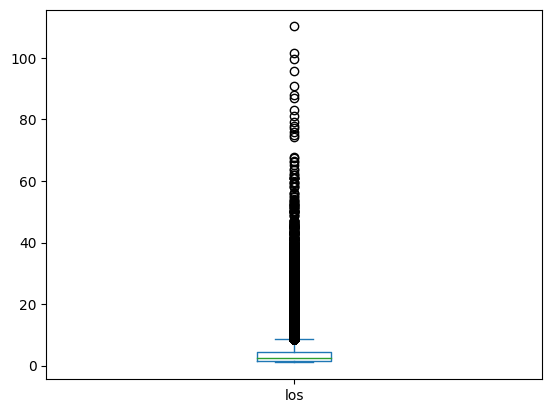

In [ ]:
df_modelo['los'].plot.box()

<Axes: >

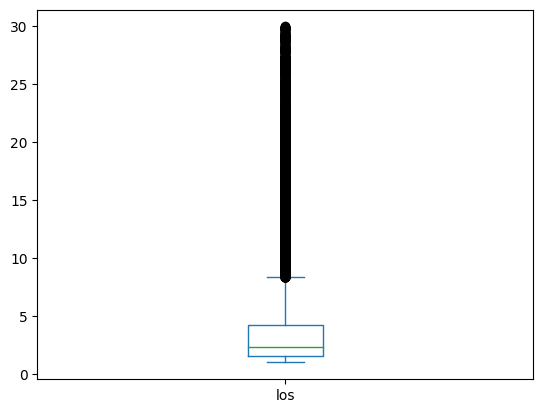

In [ ]:
df_modelo.loc[df_modelo['los'] <= 30,'los'].plot.box()

In [ ]:
df_modelo['los'].describe()

count    53710.000000
mean         4.144484
std          5.261509
min          1.000046
25%          1.551499
50%          2.370475
75%          4.344138
max        110.232280
Name: los, dtype: float64

<Axes: ylabel='Frequency'>

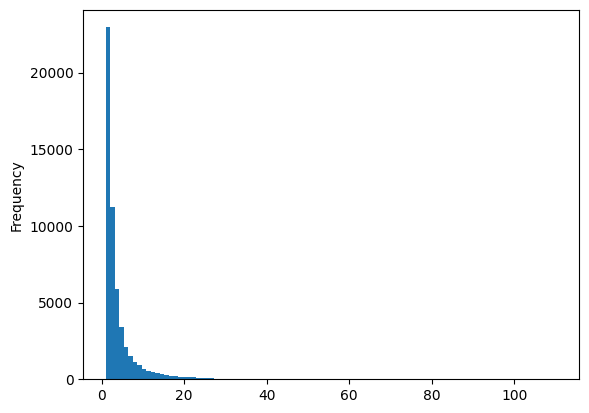

In [ ]:
df_modelo['los'].plot.hist(bins=100)

####**Suas análises**####

* Faça análises similares para outras variáveis que você considerar relevantes.
* Alguma variável tem valores estranhos? Como você trataria esse problema? Aqui é essencial conhecimento sobre a faixa de valores que cada variável pode assumir. Por exemplo, analise a variável weight. 

## 4. Análise de correlação entre as variáveis



In [ ]:
for c in variaveis_numericas:
    df_modelo[c] = df_modelo[c].apply(lambda x : float(x))

In [ ]:
#_ = sns.pairplot(df_modelo[variaveis_numericas + ['los']], kind="reg", diag_kind="kde", plot_kws={"scatter_kws": {'s': 3, 'color':'black'}}) #2min

In [ ]:
df_modelo[variaveis_numericas + ['los']].corr()

,heart_rate_mean,sbp_mean,dbp_mean,resp_rate_mean,temperature_mean,spo2_mean,glucose_mean,age,weight,height,los
heart_rate_mean,1.000000,-0.105863,0.214018,0.367766,0.236752,-0.114732,0.008782,-0.194803,0.007742,-0.013009,0.091079
sbp_mean,-0.105863,1.000000,0.517999,-0.030232,0.073281,-0.009610,-0.007334,0.011870,0.026038,-0.005347,-0.040897
dbp_mean,0.214018,0.517999,1.000000,0.061263,0.064001,-0.086473,-0.003511,-0.320429,0.041841,0.065665,-0.032333
resp_rate_mean,0.367766,-0.030232,0.061263,1.000000,0.152827,-0.258508,0.004971,0.035551,0.026888,-0.019744,0.129859
temperature_mean,0.236752,0.073281,0.064001,0.152827,1.000000,0.004151,-0.002216,-0.182736,0.052648,0.030748,0.090309
spo2_mean,-0.114732,-0.009610,-0.086473,-0.258508,0.004151,1.000000,-0.003241,-0.076048,-0.090170,-0.007370,0.013813
glucose_mean,0.008782,-0.007334,-0.003511,0.004971,-0.002216,-0.003241,1.000000,-0.003308,0.001094,-0.007385,0.001934
age,-0.194803,0.011870,-0.320429,0.035551,-0.182736,-0.076048,-0.003308,1.000000,-0.111619,-0.120005,-0.020405
weight,0.007742,0.026038,0.041841,0.026888,0.052648,-0.090170,0.001094,-0.111619,1.000000,0.202401,0.031580
height,-0.013009,-0.005347,0.065665,-0.019744,0.030748,-0.007370,-0.007385,-0.120005,0.202401,1.000000,-0.012012


## 5. Previsão de dias de hospitalização no CTI

### Regressão linear múltipla###

* Note que nessa seção utilizaremos a biblioteca [statsmodels](https://www.statsmodels.org/stable/index.html) que nos fornece informações relevantes sobre a regressão não disponíveis no SKLearn.


In [ ]:
df_modelo.drop(columns = ['stay_id'], inplace=True)

Primeiro, precisamos codificar a variável categórica manualmente.

In [ ]:
codificador_genero = OneHotEncoder(handle_unknown='ignore')
g = pd.DataFrame([['F'], ['M']], columns=['gender'])
codificador_genero.fit(g)
genero_codificado = pd.DataFrame(codificador_genero.transform(df_modelo[['gender']]).toarray(), columns=['genderF', 'genderM'])
df_modelo['genderF'] = genero_codificado['genderF']
df_modelo['genderM'] = genero_codificado['genderM']

In [1]:
#implemente o modelo
#a saída abaixo é um exemplo

Note como o modelo é ruim. Vamos analisar os resíduos do modelo.

In [ ]:
df_resultados = pd.DataFrame()
df_resultados['previsao'] = list(y_pred)
df_resultados['verdadeiro'] = list(y_teste)
df_resultados['residuos'] = df_resultados['previsao'] - df_resultados['verdadeiro']
df_resultados = df_resultados.sort_values(by='residuos').reset_index(drop=True)
df_resultados.describe()

<Axes: ylabel='Frequency'>

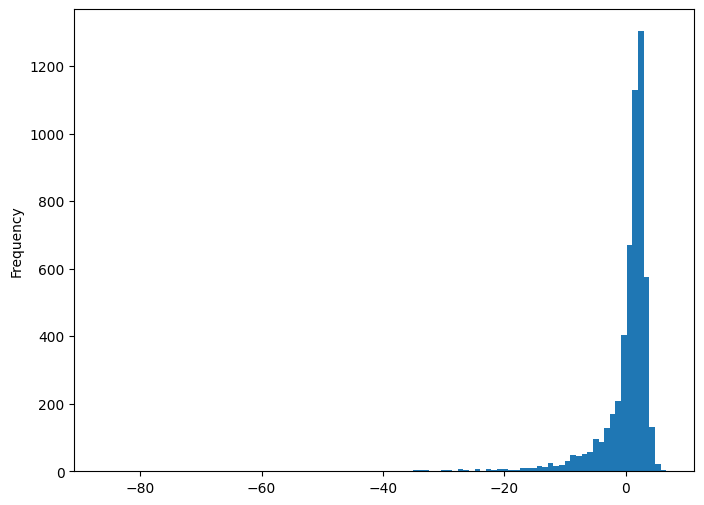

In [ ]:
df_resultados['residuos'].plot.hist(bins=100)

* Apesar de obtermos um modelo muito ruim, há uma concentração de valores de resíduos próximo de zero. 

#### **Suas análises** ####

Por que você acha que isso acontece?
Você acha que aplicar uma tranformação no eixo y utilizando um log poderia ajudar? Experimente.

In [ ]:
df_resultados = pd.DataFrame()
df_resultados['previsao'] = list(y_pred)
df_resultados['verdadeiro'] = list(y_teste)
df_resultados['residuos'] = df_resultados['previsao'] - df_resultados['verdadeiro']
df_resultados = df_resultados.sort_values(by='residuos').reset_index(drop=True)
df_resultados.describe()

In [ ]:
df_resultados['residuos'].plot.hist(bins=100)

####**Suas análises**####
Qual o efeito do uso do log? Os resultados melhoraram?
Existem outras alternativas para melhorar os resutados?
* O que fizemos foi diminuir o intervalo de variação da variável resposta, o que reflete no valor de *mean absolute error*. No entanto, o modelo continua  ruim (veja que *coefficient of determination* continua muito baixo). %APAGAR

### Modelo com xgboost
Abaixo, utilizaremos um outro modelo de regressão que não assume que as relações entre as varia'veis sejam lineares. Isso é interessante para comparar os nossos resultados.

Mean squared error: 0.31
Mean absolute error: 0.43
Root mean absolute error: 0.56
Coefficient of determination: 0.16


Text(0.5, 0, 'y_teste')

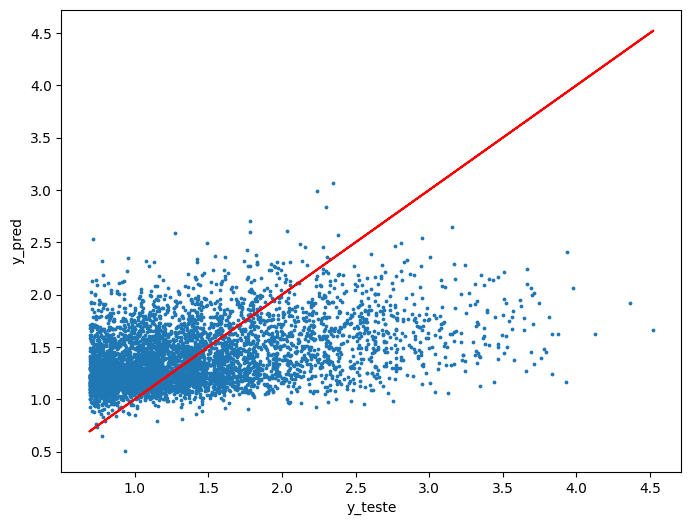

In [ ]:
import xgboost as xgb
modelo_xgb = xgb.XGBRegressor(objective="reg:squarederror", random_state=42, 
                             booster="gbtree")

modelo_xgb.fit(X_treino, y_treino)

y_pred = modelo_xgb.predict(X_teste)

print("====================================================")
print("Mean squared error: %.2f" % mean_squared_error(y_teste, y_pred))
print("Mean absolute error: %.2f" % mean_absolute_error(y_teste, y_pred))
print("Root mean absolute error: %.2f" % mean_squared_error(y_teste, y_pred, squared=False))
print("Coefficient of determination: %.2f" % r2_score(y_teste, y_pred))
print("====================================================")

plt.rcParams.update({'figure.figsize':(8,6), 'figure.dpi':100})
plt.scatter(x=y_teste, y=y_pred, s=3)
plt.plot(y_teste, y_teste, c='red')
plt.ylabel('y_pred')
plt.xlabel('y_teste')

In [ ]:
df_resultados = pd.DataFrame()
df_resultados['previsao'] = list(y_pred)
df_resultados['verdadeiro'] = list(y_teste)
df_resultados['residuos'] = df_resultados['previsao'] - df_resultados['verdadeiro']
df_resultados = df_resultados.sort_values(by='residuos').reset_index(drop=True)
df_resultados.describe()

,previsao,verdadeiro,residuos
count,5371.000000,5371.000000,5371.000000
mean,1.391346,1.384976,0.006370
std,0.284779,0.610460,0.558862
min,0.508034,0.693315,-2.859702
25%,1.179434,0.921594,-0.266011
50%,1.323611,1.203817,0.116188
75%,1.549645,1.662095,0.381799
max,3.066603,4.521938,1.814644


<Axes: ylabel='Frequency'>

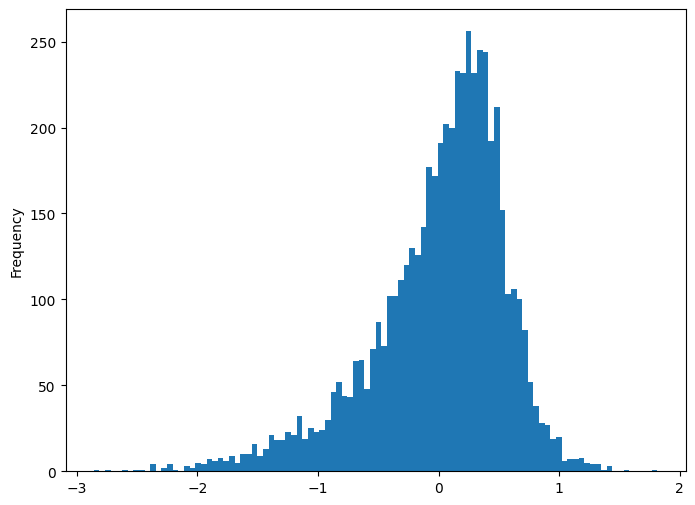

In [ ]:
df_resultados['residuos'].plot.hist(bins=100)

* O uso do XGBoost resultou em um modelo ligeiramente melhor. O *coefficient of determination* aumentou para 0.16.

##**Análises adicionais**##

* Note que os resultados do artigo base eram muito melhores dos que os obtidos aqui. Por que você acha que isso acoteceu?

* Existem outras variáveis que você poderia adicionar/retirar ao modelo? Faça alguns testes para ver se você consegue melhorar o modelo. 

* Recortar os dados de acordo com os valores da variável de resposta ajuda o modelo? Por exemplo, considerar apenas os casos em que os pacientes ficaram internados no máximo n dias. Sim ou não e por quê?

